В этой практике вы познакомитесь с тем как строить пайплайн для решения задачи обучения с учителем. На самом деле строить пайплайн с нуля даже для такой задачи как классификация кошек и собак довольно трудоемко для первой практики, поэтому многие шаги я уже приготовил. Вам нужно реализовать ключевые куски чтобы сложить картину целиком.
Для того чтобы выполнить практику, поставьте [Anaconda](https://www.anaconda.com/download) - она содержит нужные для работы библиотеки.

Зарегистрируйтесь на платформе https://kaggle.com и посмотрите конкурс https://www.kaggle.com/c/dogs-vs-cats

Скачайте данные этого конкурса https://www.kaggle.com/c/3362/download-all. Наш проект будет построен по т.н. схеме [cookiecutter](https://drivendata.github.io/cookiecutter-data-science/#cookiecutter-data-science) (прочитать про неё полезно, но не обязательно), поэтому скачанные данные распакуйте и поместите в папку `data/` внутри проекта (на деле если вы используете ссылку выше нужно распаковать дважды - архив и архивы внутри архива). Если вы используете `git`, то добавьте папку `data/` в файл `.gitignore`.

Данные для каждой практики персональны для каждого студента. Введите свое имя, фамилию и группу в строковую переменную STUDENT_ID (в произвольной форме) - это ваш уникальный идентификатор.

In [0]:
STUDENT_ID = "<Turaev Artem 411>"

Чтение данных
====

Обработаем данные. Этот шаг я сделаю за вас в силу некоторой его трудоемкости. Используем библиотеки pandas, numpy и Pillow.
- Введение в pandas и numpy можно посмотреть в первом уроке курса mlcourse_open: 
- https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_russian/topic01_pandas_data_analysis/lesson1_part0_numpy.ipynb
- https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_russian/topic01_pandas_data_analysis/lesson1_part1_pandas_intro.ipynb
- Pillow - одна из самых распространенных библиотек для работы с изображениями в python.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


%cd /content/drive/My Drive/data/
%ls
!unzip train.zip

In [3]:
from glob import glob
import os
image_paths_list = glob(os.path.join('/content/drive/My Drive/data/train', '*.jpg'))

print(len(image_paths_list))

25000


In [4]:
import pandas as pd
import pathlib
import hashlib
import numpy as np
import random


train_directory = pathlib.Path("/content/drive/My Drive/data/train")
sample_size = 5000

def initialize_random_seed():
    """Инициализирует ГПСЧ из STUDENT_ID"""
    sha256 = hashlib.sha256()
    sha256.update(STUDENT_ID.encode("utf-8"))
    
    fingerprint = int(sha256.hexdigest(), 16) % (2**32) 
    
    random.seed(fingerprint)
    np.random.seed(fingerprint)


def read_target_variable():
    """Прочитаем разметку фотографий из названий файлов"""
    target_variable = {
        "filename": [],
        "is_cat": []
    }
    image_paths = list(train_directory.glob("*.jpg"))
    random.shuffle(image_paths)
    for image_path in image_paths[:sample_size]:
        filename = image_path.name
        class_name = filename.split(".")[0]
        target_variable["filename"].append(filename)
        target_variable["is_cat"].append(class_name == "cat")

    return pd.DataFrame(data=target_variable)


initialize_random_seed()

target_df = read_target_variable()
target_df

,filename,is_cat
0,dog.1561.jpg,False
1,dog.6662.jpg,False
2,cat.5386.jpg,True
3,dog.11026.jpg,False
4,cat.2033.jpg,True
...,...,...
4995,cat.151.jpg,True
4996,dog.181.jpg,False
4997,cat.1746.jpg,True
4998,cat.10402.jpg,True


Обработка изображений
====

Используем изображения в качестве признакового описания. Признаками будут значения конкретных пикселей.

In [5]:
from PIL import Image
from tqdm import tqdm_notebook


def read_data(target_df):
    """Читает данные изображений и строит их признаковое описание"""
    image_size = (100, 100)
    features = []
    target = []
    for i, image_name, is_cat in tqdm_notebook(target_df.itertuples(), total=len(target_df)):
        image_path = str(train_directory / image_name)
        image = Image.open(image_path)
        image = image.resize(image_size) # уменьшаем изображения
        image = image.convert('LA') # преобразуем в Ч\Б
        pixels = np.asarray(image)[:, :, 0]
        pixels = pixels.flatten()
        features.append(pixels)
        target.append(is_cat)
    return np.array(features), np.array(target)

features, target = read_data(target_df)
features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


array([[123, 126, 128, ..., 181, 179, 178],
       [125, 125, 143, ..., 114,  97, 109],
       [ 22,  26,  28, ...,  17,  20,  19],
       ...,
       [ 11,  31,  34, ...,  27,  25,  24],
       [ 17,  15,  16, ..., 112, 109, 107],
       [187, 178, 178, ..., 107, 116, 113]], dtype=uint8)

Разбиение на обучающую, валидационную и тестовую выборки
====

Сделайте обучающую, валидационную и тестовую выборки в пропорции 60/20/20. Используйте библиотеку scikit-learn (метод train_test_split). 

Документация: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Советую изучить готовый пайплайн для другой задачи, чтобы примерно понимать что требуется делать дальше (в отличии от нашего пайплайна тут нет валидационного множества): https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html 


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, train_size=0.6)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

print(len(X_train))
print(len(X_test))
print(len(X_valid))
X_train

3000
1000
1000


array([[186, 186, 187, ..., 112, 108, 110],
       [117,  95,  77, ...,  94,  91,  95],
       [ 37,  38,  40, ..., 175, 178, 172],
       ...,
       [ 93,  95,  93, ...,  17,  16,  71],
       [ 50,  50,  51, ...,  91,  91,  84],
       [118, 118, 118, ..., 190, 184, 178]], dtype=uint8)

In [7]:
dogs = 0

is_dog = lambda x: 1 if x == False else 0

for i in y_train:
    dogs += is_dog(i)

dogs

1516

True


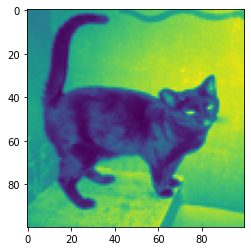

In [8]:
import matplotlib.pyplot as plt
I=2000

plt.imshow(X_train[I].reshape(100, 100))
print(y_train[I])

Обучение модели
====

Попробуйте обучить модель `sklearn.linear_model.SGDClassifier` на полученных данных. Если это занимает слишком много времени и ресурсов - уменьшайте размер выборки (переменная sample_size).

Документация: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [9]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=33)

clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print('test score', score)
score = clf.score(X_train, y_train)
print('train score(overfitting)', score) 

test score 0.531
train score(overfitting) 0.8833333333333333


Настройка гиперпараметров
====

Подберите скорость обучения модели, оценивая долю верных ответов (scikit-learn accuracy_score) на валидационном множестве (подбираем параметр `eta0` в отрезке [0, 1] указав параметр `learning_rate="constant"`).

In [ ]:
# clf = SGDClassifier(max_iter=900, tol=1e-3, loss='squared_loss', penalty='l2')
# clf.learning_rate = 'constant'

# best_eta = 0
# score_var = 0
# part = 100
# for i in tqdm_notebook(range(1, part + 1)):
#     eta0_var = i / part
#     clf.eta0 = eta0_var
#     clf.fit(X_train, X_train_target)
#     score = clf.score(X_valid, X_valid_target)
#     if score > score_var:
#         score_var = score
#         best_eta = eta0_var
        
# clf.eta0 = best_eta
# clf

In [0]:
clf = SGDClassifier(learning_rate='constant', eta0=0.83, max_iter=1100, tol=1e-4, loss='squared_loss', random_state=33)

Оценка результатов
====

Оцените долю верных ответов модели (scikit-learn accuracy_score). Каков уровень переобучения?

In [11]:
from sklearn.metrics import accuracy_score

clf.fit(X_train, y_train)

print("train \t\t", clf.score(X_train, y_train))
print("validation \t", clf.score(X_valid, y_valid))

predict = clf.predict(X_test)
print("test \t\t", accuracy_score(y_test, predict))

train 		 0.5096666666666667
validation 	 0.496
test 		 0.497


Нормализация данных
====

Сделайте нормализацию данных с помощью StandardScaler из библиотеки sklearn (scaler.fit_transform на train и validation, scaler.transform на test). Оцените долю верных ответов модели на тестовой выборке. Какова ситуация теперь?

Документация: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.transform(X_test)

In [13]:
clf = SGDClassifier(learning_rate='constant', eta0=0.83, max_iter=1100, tol=1e-4, loss='squared_loss', random_state=33)
clf.fit(X_train, y_train)
print("train \t\t", clf.score(X_train, y_train))
print("validation \t", clf.score(X_valid, y_valid))
print("test \t\t", clf.score(X_test, y_test))

train 		 0.49566666666666664
validation 	 0.539
test 		 0.494


Сабмит на kaggle
====

(Опционально) сделайте сабмит в конкурсе https://www.kaggle.com/c/dogs-vs-cats (это простой бейзлайн, не ожидайте высокого результата)

# Random Forest

Примените RandomForest вместо SGDClassifier на этой задаче. Подберите количество деревьев, перебирая их в интервале от 100 до 400.


Оцените качество RandomForest на кросс-валидации по пяти фолдам. Посмотрите на среднее и стандартное отклонение точности на кросс-валидации.

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=210, random_state=33)
clf.fit(X_train, y_train)

print("validation \t", clf.score(X_valid, y_valid))
print("test \t\t", clf.score(X_test, y_test))

validation 	 0.622
test 		 0.636


In [15]:
from sklearn.model_selection import cross_val_score
from numpy import mean, std, var

cross_val_value = cross_val_score(clf, X_test, y_test, cv=5)
print(cross_val_value)
print("mean value \t\t", mean(cross_val_value))
print("standard deviation \t", std(cross_val_value))
print("dispersion \t\t", var(cross_val_value))

[0.615 0.565 0.57  0.625 0.58 ]
mean value 		 0.591
standard deviation 	 0.0243721152139079
dispersion 		 0.000594000000000001
